# Analyzing neural data with SING and gpSLDS

In this notebook, we'll use SING to fit Gaussian process switching linear dynamical systems (gpSLDS) from Hu et al. (2024) [1].

The gpSLDS is a latent SDE model with a Gaussian process prior on the drift function. The Gaussian process is parametrized by the "smoothly switching linear" kernel, which encourages the inferred drift to have smooth, piecewise linear structure akin to standard SLDS models. 

We'll be analyzing neural data from Vinograd et al. (2024) [2], which studies neural dynamics during participation in and observation of aggressive behavior in mice. 

**References:**

[1] Hu, A., Zoltowski, D., Nair, A., Anderson, D., Duncker, L., & Linderman, S. (2024). Modeling latent neural dynamics with gaussian process switching linear dynamical systems. Advances in Neural Information Processing Systems, 37, 33805-33835.

[2] Vinograd, A., Nair, A., Kim, J. H., Linderman, S. W., & Anderson, D. J. (2024). Causal evidence of a line attractor encoding an affective state. Nature, 634(8035), 910-918.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Jax imports
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random as jr
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

# Other imports
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

In [3]:
# Check that we are on GPU
print(jax.devices())

[CudaDevice(id=0)]


## Load in neural data
First, we will load in the recorded neural activity from a mouse participating in aggressive behavior. 

In [4]:
import lindi

url = 'https://api.dandiarchive.org/api/assets/1e11c74e-6f25-4604-9216-5b861fec8f1c/download/'

# Load the remote file
f = lindi.LindiH5pyFile.from_hdf5_file(url)

# load the neurodata object (TimeSeries)
NeuralTrace = f['/processing/ophys/NeuralTrace']
neural = NeuralTrace['data'][:]
rate = 10 # 10 Hz

Let's check the size of the dataset and save some parameters.

In [5]:
print(f"shape of neural activity: {neural.shape}")
n_timesteps, n_neurons = neural.shape
t_max = n_timesteps / rate
t_grid = jnp.linspace(0, t_max, n_timesteps)
dt = 1. / rate # seconds per bin
n_trials = 1

print(f"trial duration: {t_max}")
print(f"seconds per bin: {dt}")

shape of neural activity: (4201, 56)
trial duration: 420.1
seconds per bin: 0.1


We'll also z-score the activity for each neuron before data analysis and model fitting.

In [6]:
# normalize data
norm_neural = (neural - neural.mean(0)) / neural.std(0)

## Exploratory data analysis

The first step of doing good data science is exploratory data analysis! In this section, we will
- Visualize the neural data and observe any patterns
- Perform standard dimensionality reduction to analyze preliminary latent trajectories
- Contruct any relevant external inputs to the system

Let's visualize the normalized neural data matrix:

In [7]:
# Set font and label size for all plots
fontsize = 14
labelsize = 11

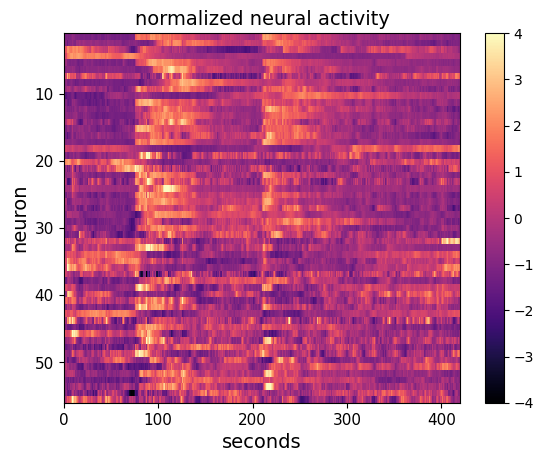

In [8]:
fig, ax = plt.subplots()

im = ax.imshow(
    norm_neural.T,
    aspect='auto',
    extent=[0, t_max, n_neurons, 1],
    interpolation='none',
    vmin=-4,
    vmax=4,
    cmap='magma'
)

ax.set_xticks([0, 100, 200, 300, 400])
ax.set_xlabel('seconds', fontsize=fontsize)     # set xlabel font size
ax.set_ylabel('neuron', fontsize=fontsize)      # set ylabel font size
ax.set_title('normalized neural activity', fontsize=fontsize)  # set title font size

ax.tick_params(axis='both', which='major', labelsize=labelsize)  # set tick label size

fig.colorbar(im, ax=ax)

From this plot, we observe time-locked activity between several groups of neurons, suggesting that there exists some lower-dimensional structure. Furthermore, neural activity seems to change suddenly at around 80 seconds and 210 seconds, which corresponds to the entrance of two intruder mice (see [2]). Later, we will model these two events as external inputs to the system.

Next, we'll perform principal components analysis (PCA) to get a preliminary understanding of lower dimensional structure.

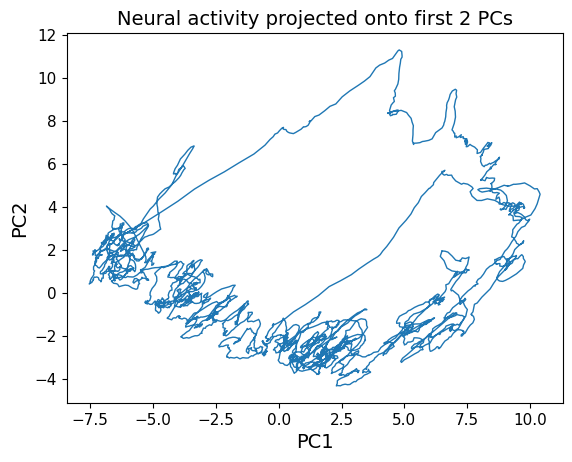

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
neural_pca = pca.fit_transform(norm_neural)

fig, ax = plt.subplots()
ax.plot(neural_pca[:, 0], neural_pca[:, 1], lw=1)

ax.set_xlabel('PC1', fontsize=fontsize)
ax.set_ylabel('PC2', fontsize=fontsize)
ax.set_title('Neural activity projected onto first 2 PCs', fontsize=fontsize)

ax.tick_params(axis='both', which='major', labelsize=labelsize)

We observe that there are two intervals of rapidly changing latent trajectories which likely correspond to the two intruders. We can model these as constant inputs during these two short intervals. Here, we pick intervals such that they cover these two periods of rapid change in the latent factors:

In [11]:
# set input times
input1_times = jnp.array([74, 80]) # time interval (in seconds) of 1st intruder entrance
input2_times = jnp.array([207, 212]) # time interval (in seconds) of 2nd intruder entrance

# convert to indices
input1_inds = (input1_times * rate).astype(int) 
input2_inds = (input2_times * rate).astype(int)

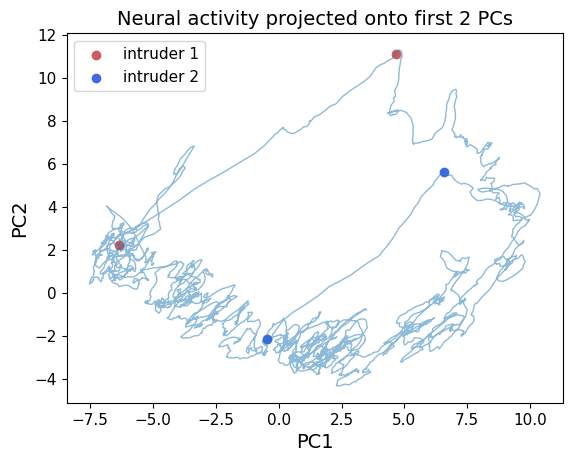

In [12]:
fig, ax = plt.subplots()

# Trajectory
ax.plot(neural_pca[:, 0], neural_pca[:, 1], lw=1, alpha=0.5)

# Intruder 1 markers
ax.scatter(neural_pca[input1_inds[0], 0], neural_pca[input1_inds[0], 1], color='indianred', label='intruder 1')
ax.scatter(neural_pca[input1_inds[1], 0], neural_pca[input1_inds[1], 1], color='indianred')

# Intruder 2 markers
ax.scatter(neural_pca[input2_inds[0], 0], neural_pca[input2_inds[0], 1], color='royalblue', label='intruder 2')
ax.scatter(neural_pca[input2_inds[1], 0], neural_pca[input2_inds[1], 1], color='royalblue')

# Labels and legend
ax.set_xlabel('PC1', fontsize=fontsize)
ax.set_ylabel('PC2', fontsize=fontsize)
ax.set_title('Neural activity projected onto first 2 PCs', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)
ax.legend(fontsize=labelsize)

Now we can construct step-function inputs during these time intervals:

Text(0.5, 0.98, 'constructed inputs')

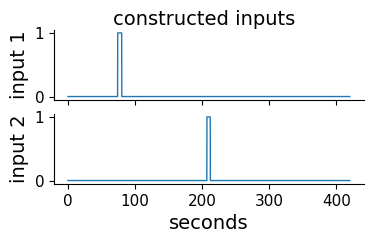

In [13]:
n_inputs = 2 # one input dimension per intruder
inputs = np.zeros((n_trials, n_timesteps, n_inputs))
inputs[:,input1_inds[0]:(input1_inds[1]+1),0] = 1.
inputs[:,input2_inds[0]:(input2_inds[1]+1),1] = 1.

fig, axs = plt.subplots(n_inputs, 1, figsize=(4, 2), sharex=True)

for i, ax in enumerate(axs.ravel()):
    ax.plot(t_grid, inputs[0, :, i], lw=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(f'input {i+1}', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize)

axs[1].set_xlabel('seconds', fontsize=fontsize)
fig.suptitle('constructed inputs', fontsize=fontsize)

While PCA is great for preliminary dimensionality reduction, it assumes that neural activity across timesteps is i.i.d.; however, we know (and can see from the plots above) that there are rich correlations between timesteps. Furthermore, we often would like to infer approximate posterior distributions over these latent trajectories, as well as infer the underlying *dynamics* (i.e. a flow field) that explains the evolution of these trajectories. This motivates the use of SING, which we demonstrate in the next section.

## Fitting gpSLDS with SING
In this section, we will demonstrate how to fit gpSLDS models [1] with SING. This consists of the following steps:
- Prepare data and inputs
- Initialize model and parameters
- Fit the model!

### Prepare data for SING
SING is implemented in JAX, so here we convert all data (i.e. observations and inputs) to `jnp.array`. We also contruct an array `t_mask`, which is a binary mask indicating which time bins are observed. In this case, all time bins have observations, so this is an array of ones.

In [14]:
ys = jnp.array(norm_neural[None]) # neural activity
t_mask = jnp.ones((n_trials, n_timesteps)) # binary mask indicating time bins with observations
inputs = jnp.array(inputs) # inputs

### Initialize gpSLDS model

Here, we initialize the gpSLDS model and parameters before fitting. Our model for the latent states is, $$d\boldsymbol{x}(t) = (\boldsymbol{f}(\boldsymbol{x}) + \boldsymbol{B} \boldsymbol{v}(t))dt + \boldsymbol{\Sigma}^{1/2} d\boldsymbol{w}(t),$$ where $\boldsymbol{x}(t) \in \mathbb{R}^D$ is the latent state at time $t$, $\boldsymbol{f}(x)$ is the drift function, $\boldsymbol{v}(t) \in \mathbb{R}^I$ is the input at time $t$, $\boldsymbol{B} \in \mathbb{R}^{D \times I}$ is a linear input effect matrix, and $\boldsymbol{\Sigma}$ is the latents noise covariance.

In the gpSLDS, the drift function $\boldsymbol{f}(\boldsymbol{x})$ is modeled with the Gaussian process prior, $\boldsymbol{f}_d \sim \mathcal{GP}(0, k_{\text{SSL}}(\cdot, \cdot)),$ where the kernel covariance function is $$k_{\text{SSL}}(\boldsymbol{x}, \boldsymbol{x}') = \sum_{j=1}^J ((\boldsymbol{x} - \boldsymbol{c}_j)^\top \boldsymbol{M} (\boldsymbol{x}'-\boldsymbol{c}_j) + \sigma_0^2) \pi_j(\boldsymbol{x}) \pi_j(\boldsymbol{x}'), \ \boldsymbol{x}, \boldsymbol{x}' \in \mathbb{R}^D$$ Here, $J$ is the number of linear regimes, $\pi: \mathbb{R}^D \to \Delta^{J-1}$ is a function mapping each location in latent space to a probability of being in each linear regime, and $\{\{\boldsymbol{c}_j\}_{j=1}^J, \boldsymbol{M}, \sigma_0^2\}$ are kernel hyperparameters. $\pi(\cdot)$ also has a temperature hyperparameter $\tau$ controlling the sharpness of decision boundaries between regimes. 

The above kernel corresponds to using `SSL` with `FullLinear` kernel parametrization in the code (see below). There are also other options for different kernel parametrizations in the file `kernels.py`.

In [15]:
# SING imports
from sing.likelihoods import Gaussian
from sing.inputs import InputSignals
from sing.sde import SparseGP
from sing.kernels import SSL, FullLinear
from sing.initialization import initialize_params_pca

We'll initialize the latent dimensionality, likelihood and inputs objects, the drift object with kernel parameters, and the output mapping parameters. 

In [16]:
# set latent dimensionality
latent_dim = 2

# initialize likelihood object
likelihood = Gaussian(ys, t_mask)

# construct inputs object
input_signals = InputSignals(inputs)

# initialize GP kernel
linear_kernel = FullLinear(latent_dim)
num_states = 4 # number of linear states/regimes (J) for gpSLDS
basis_set = lambda x: jnp.array([1., x[0], x[1]])
num_bases = 3 # length of basis_set output
kernel = SSL(linear_kernel, basis_set, latent_dim)

# initialize SDE with GP prior
zs = jnp.meshgrid(  # inducing points
    jnp.linspace(-8, 10, 8),
    jnp.linspace(-4, 12, 8)
)
zs = jnp.column_stack([zs[0].ravel(), zs[1].ravel()])
fn = SparseGP(zs, kernel)

# initialize kernel hyperparameters
key = jr.PRNGKey(20)
key_W, key_fp = jr.split(key, 2)
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64)
fp_init = tfd.Normal(0, 1).sample((num_states, latent_dim), seed=key_fp).astype(jnp.float64)
tau_init = 0.5
kernel_params_init = {
    'linear_params': [{"fixed_point": fp_init[i], 'log_M': jnp.zeros(latent_dim), 'log_noise_var': 0.} for i in range(num_states)],
    'W': W_init,
    'log_tau': jnp.log(tau_init)
}

# initialize output parameters using PCA
output_params_init, x0_init_params = initialize_params_pca(latent_dim, ys)

# initialize the prior on latent state in first time step, p(x0) = N(x0|mu0,V0)
init_params = {
    'mu0': x0_init_params,
    'V0': jnp.eye(latent_dim)[None].repeat(n_trials, 0)
}

### Fit the model!

Before fitting the model, we recommend **commenting out the updates to `output_params` in `sing.py`**. 

This means that we'll be performing inference and learning within the subspace we initialize at, which in this case is the PCA subspace. Empirically, this is often sufficient for learning meaningful representations and can allow for faster learning of the other model parameters.

In [17]:
from sing.sing import fit_variational_em

key = jr.PRNGKey(1) # for minibatching across trials (not used here)
n_iters = 30
n_iters_e = 15
n_iters_m = 50

rho_sched_0 = jnp.logspace(-1, 0, 10)
rho_sched_1 = rho_sched_0[-1] * jnp.ones(n_iters - len(rho_sched_0))
rho_sched = jnp.concatenate([rho_sched_0, rho_sched_1])

learning_rate = 1e-4 * jnp.ones(n_iters)

results_sing = fit_variational_em(key, 
                                  fn, 
                                  likelihood, 
                                  t_grid, 
                                  kernel_params_init, 
                                  init_params, 
                                  output_params_init, 
                                  input_signals=input_signals, # include inputs
                                  batch_size=None, 
                                  rho_sched=rho_sched, 
                                  learning_rate=learning_rate, 
                                  n_iters=n_iters, 
                                  n_iters_e=n_iters_e, 
                                  n_iters_m=n_iters_m)

Initializing params...
Performing variational EM algorithm...
Iteration 1 / 30, ELBO: -208414.23038712316, ell: -206479.690644393, KL: 1460.5770890298386, prior: -473.96265370032813
Iteration 2 / 30, ELBO: -208390.3401318205, ell: -206321.92386600492, KL: 1595.1642436141776, prior: -473.25202220139624
Iteration 3 / 30, ELBO: -208388.63330397272, ell: -206304.48542561056, KL: 1611.606132435174, prior: -472.54174592696893
Iteration 4 / 30, ELBO: -208387.68342552244, ell: -206303.410898873, KL: 1612.307223992742, prior: -471.9653026566966
Iteration 5 / 30, ELBO: -208386.85605613264, ell: -206303.42181475216, KL: 1611.9737409563654, prior: -471.4605004241237
Iteration 6 / 30, ELBO: -208385.9928137451, ell: -206303.45814012142, KL: 1611.5919716748429, prior: -470.9427019488358
Iteration 7 / 30, ELBO: -208385.31360065244, ell: -206303.50846543163, KL: 1611.178878139617, prior: -470.6262570812074
Iteration 8 / 30, ELBO: -208384.64431475097, ell: -206303.5765541601, KL: 1610.7625842425152, pri

In [18]:
# unpack results
marginal_params, natural_params, gp_post, kernel_params, init_params, output_params, input_effect, elbos = results_sing
ms_final, Ss_final, _ = marginal_params # posterior marginal mean and cov of latent states

## Plot results
Let's plot the inferred latent states and dynamics from the model. 

In [19]:
# define functions for getting the posterior mean and var of drift f(.) at each point x
posterior_f_mean = lambda x: (fn.get_posterior_f_mean(gp_post, kernel_params, x[None]))[0]
dynamics_var_fn = lambda x: jnp.linalg.det(fn.get_posterior_f_var(gp_post, kernel_params, x[None]))

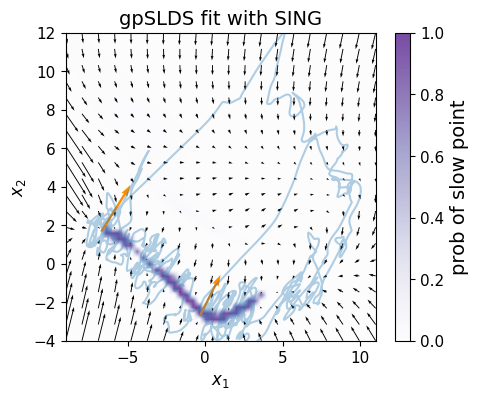

In [22]:
from sing.plotting import plot_dynamics_and_latents_2d, plot_slow_points_2d

fig, ax = plt.subplots(figsize=(5, 4))
ax = plot_dynamics_and_latents_2d(posterior_f_mean, ms_final, xlim=(-9, 11), ylim=(-4, 12), n_xpts=20, n_ypts=20, latents_alpha=0.35, ax=ax)
ax, im = plot_slow_points_2d(posterior_f_mean, dynamics_var_fn, xlim=(-9, 11), ylim=(-4, 12), n_xpts=50, n_ypts=50, alpha=0.7, eps=0.15, ax=ax)

i1 = input1_inds[0]
i2 = input2_inds[0]
ax.quiver(ms_final[0,i1,0], ms_final[0,i1,1], input_effect[0,0], input_effect[1,0], angles='xy', scale_units='xy', scale=1, color='darkorange')
ax.quiver(ms_final[0,i2,0], ms_final[0,i2,1], input_effect[0,1], input_effect[1,1], angles='xy', scale_units='xy', scale=1, color='darkorange')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.set_label('prob of slow point', fontsize=fontsize)
cbar.ax.tick_params(labelsize=labelsize)

ax.set_title('gpSLDS fit with SING', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=labelsize)

Above, we have plotted:
- Posterior mean of inferred latent states (blue line)
- Posterior mean of inferred dynamics (black arrows)
- Posterior probability of slow points, i.e. dynamics being close to 0 (purple)
- Direction of learned input effect $B$ per intruder (orange arrows)

We find results consistent with [2], suggesting that mice participating in aggression do exhibit attractor dynamics in a low-d latent space. The probabilistic modeling of the dynamics with the gpSLDS allows us to precisely identify the location of this approximate line attractor. 